<a href="https://colab.research.google.com/github/sarahmurshed/Project3SarahMurshedAER850/blob/main/Project3_AER850.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
# STEP 1: OBJECT MASKING
input_path = "/content/motherboard_image.JPEG"
output_dir = "/content/outputs_step1"
os.makedirs(output_dir, exist_ok=True)

# Load Image
img = cv2.imread(input_path)
if img is None:
    raise FileNotFoundError(f"Could not read image at {input_path}")

orig = img.copy()

# Convert to Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Blur
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Thresholding
_, thresh = cv2.threshold(
    blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)
cv2.imwrite(os.path.join(output_dir, "01_threshold.png"), thresh)


# Edge Detection
edges = cv2.Canny(thresh, 50, 150)
cv2.imwrite(os.path.join(output_dir, "02_edges.png"), edges)


# 1) Threshold
_, thresh = cv2.threshold(
    blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# Invert (board is white bg is black)
thresh_inv = cv2.bitwise_not(thresh)

# Clean up Small Holes
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
thresh_clean = cv2.morphologyEx(thresh_inv, cv2.MORPH_CLOSE, kernel)

cv2.imwrite(os.path.join(output_dir, "01_threshold_inv_clean.png"), thresh_clean)

# 2) Canny
edges = cv2.Canny(blur, 50, 150)
cv2.imwrite(os.path.join(output_dir, "02_edges.png"), edges)

# 3) Contours
contours, hierarchy = cv2.findContours(
    thresh_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

print(f"Found {len(contours)} contours")


min_area = 5000
large_contours = [c for c in contours if cv2.contourArea(c) > min_area]

pcb_contour = max(large_contours, key=cv2.contourArea)
print("PCB contour area:", cv2.contourArea(pcb_contour))

# Visualize Selected Contour
contour_vis = orig.copy()
cv2.drawContours(contour_vis, [pcb_contour], -1, (0, 0, 255), 3)
cv2.imwrite(os.path.join(output_dir, "03_pcb_contour.png"), contour_vis)

# 4) Create Mask from that Contour
mask = np.zeros(gray.shape, dtype=np.uint8)
cv2.drawContours(mask, [pcb_contour], -1, 255, thickness=-1)
cv2.imwrite(os.path.join(output_dir, "04_mask.png"), mask)

# 5) Extract PCB
extracted = cv2.bitwise_and(orig, orig, mask=mask)
cv2.imwrite(os.path.join(output_dir, "05_extracted_motherboard.png"), extracted)

Found 216 contours
PCB contour area: 7992535.0


True

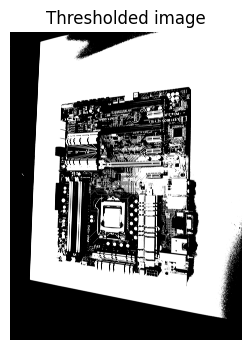

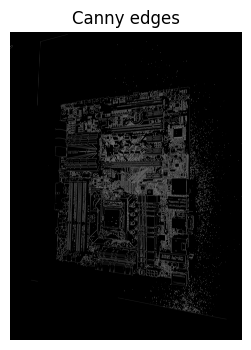

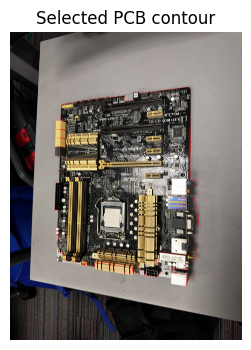

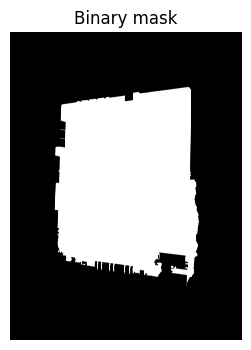

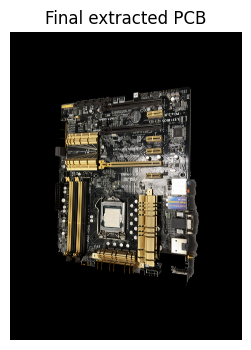

In [ ]:
def show_img(path, cmap=None, title=""):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        print("Could not read:", path)
        return

    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,4))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

base = "/content/outputs_step1"

show_img(os.path.join(base, "01_threshold.png"), cmap="gray", title="Thresholded image")
show_img(os.path.join(base, "02_edges.png"), cmap="gray", title="Canny edges")
show_img(os.path.join(base, "03_pcb_contour.png"), title="Selected PCB contour")
show_img(os.path.join(base, "04_mask.png"), cmap="gray", title="Binary mask")
show_img(os.path.join(base, "05_extracted_motherboard.png"), title="Final extracted PCB")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

base_dir = "/content/drive/MyDrive/Project3"
project_data_dir = os.path.join(base_dir, "Project 3 Data")

print("Base directory:", base_dir)
print("Contents of base directory:", os.listdir(base_dir))

print("Project data dir:", project_data_dir)

Base directory: /content/drive/MyDrive/Project3
Contents of base directory: ['.DS_Store', 'data.zip', 'motherboard_image.JPEG', 'prediction imgs', '__MACOSX']
Project data dir: /content/drive/MyDrive/Project3/Project 3 Data


In [ ]:
import zipfile, os

data_zip = os.path.join(base_dir, "data.zip")
with zipfile.ZipFile(data_zip, 'r') as z:
    z.extractall(base_dir)

data_dir = os.path.join(base_dir, "data")

print("Data dir:", data_dir)
print("Top-level contents:", os.listdir(data_dir))

Data dir: /content/drive/MyDrive/Project3/data
Top-level contents: ['data.yaml', 'evaluation', 'test', 'train', 'valid']


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.4 MB/s eta 0:00:00


In [ ]:
# STEP 2: YOLOV11 TRAINING
from ultralytics import YOLO
import os

data_yaml = os.path.join(data_dir, "data.yaml")
print("Using YAML:", data_yaml)

model = YOLO("yolo11n.pt")

# Train
results = model.train(
    data=data_yaml,
    epochs=100,
    batch=8,
    imgsz=1024,
    name="pcb_yolo11n_100e",
    project=os.path.join(base_dir, "runs")
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using YAML: /content/drive/MyDrive/Project3/data/data.yaml
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Project3/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=Fals

In [ ]:
run_dir = os.path.join(base_dir, "runs", "pcb_yolo11n_100e")
print("Run directory:", run_dir)
print(os.listdir(run_dir))

Run directory: /content/drive/MyDrive/Project3/runs/pcb_yolo11n_100e
['weights', 'args.yaml', 'labels.jpg', 'train_batch0.jpg', 'train_batch2.jpg', 'train_batch1.jpg', 'results.csv', 'train_batch6120.jpg', 'train_batch6121.jpg', 'train_batch6122.jpg', 'val_batch0_pred.jpg', 'val_batch1_pred.jpg', 'val_batch0_labels.jpg', 'val_batch1_labels.jpg', 'val_batch2_pred.jpg', 'val_batch2_labels.jpg', 'BoxPR_curve.png', 'BoxF1_curve.png', 'BoxP_curve.png', 'BoxR_curve.png', 'confusion_matrix_normalized.png', 'confusion_matrix.png', 'results.png']


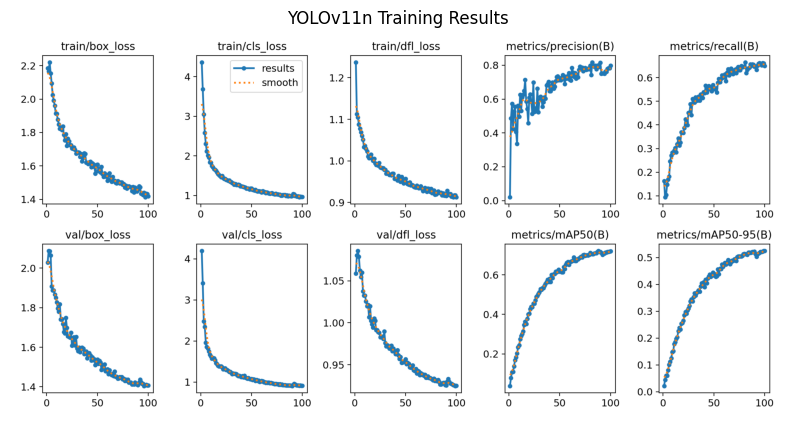

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

results_img_path = os.path.join(run_dir, 'results.png')

def show_image(path, title=""):
    img = cv2.imread(path)
    if img is None:
        print(f"Could not load image: {path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

show_image(results_img_path, title="YOLOv11n Training Results")

In [ ]:
import pandas as pd

results_csv_path = os.path.join(run_dir, 'results.csv')
results_df = pd.read_csv(results_csv_path)
display(results_df.head())

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,91.3481,2.18513,4.36626,1.23720,0.02012,0.16268,0.03814,0.02172,2.02748,4.19615,1.05863,0.000193,0.000193,0.000193
1,2,133.7090,2.16602,3.68616,1.11242,0.48578,0.09380,0.07930,0.04479,2.08695,3.40991,1.08038,0.000385,0.000385,0.000385
2,3,176.7790,2.22079,3.05117,1.10469,0.57177,0.10359,0.10806,0.06009,2.08473,2.48202,1.08572,0.000574,0.000574,0.000574
3,4,220.2920,2.15386,2.58601,1.08745,0.42407,0.14704,0.10933,0.05951,2.06355,2.34861,1.07879,0.000571,0.000571,0.000571
4,5,262.2250,2.09458,2.30865,1.07708,0.52571,0.16996,0.13777,0.08090,1.90773,1.96126,1.06204,0.000565,0.000565,0.000565


from matplotlib import pyplot as plt
_df_0['epoch'].plot(kind='hist', bins=20, title='epoch')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['time'].plot(kind='hist', bins=20, title='time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['train/box_loss'].plot(kind='hist', bins=20, title='train/box_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['train/cls_loss'].plot(kind='hist', bins=20, title='train/cls_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='epoch', y='time', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='time', y='train/box_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='train/box_loss', y='train/cls_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='train/cls_loss', y='train/dfl_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['train/box_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('train/box_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['train/cls_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('train/cls_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['train/dfl_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('train/dfl_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['metrics/precision(B)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('metrics/precision(B)')

from matplotlib import pyplot as plt
_df_12['epoch'].plot(kind='line', figsize=(8, 4), title='epoch')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['time'].plot(kind='line', figsize=(8, 4), title='time')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['train/box_loss'].plot(kind='line', figsize=(8, 4), title='train/box_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['train/cls_loss'].plot(kind='line', figsize=(8, 4), title='train/cls_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import os

root = "/content/drive/MyDrive"
yolo_yaml_paths = []

for r, d, f in os.walk(root):
    if "data.yaml" in f:
        yolo_yaml_paths.append(os.path.join(r, "data.yaml"))

print("Found data.yaml at:")
for p in yolo_yaml_paths:
    print(p)

Found data.yaml at:
/content/drive/MyDrive/Project3/data/data.yaml


In [ ]:
import os

data_yaml = "/content/drive/MyDrive/Project3/data/data.yaml"
data_dir  = os.path.dirname(data_yaml)

print("data_dir:", data_dir)
print("contents:", os.listdir(data_dir))

data_dir: /content/drive/MyDrive/Project3/data
contents: ['data.yaml', 'evaluation', 'test', 'train', 'valid']


In [ ]:
base_dir = os.path.dirname(data_dir)
run_dir  = os.path.join(base_dir, "runs", "pcb_yolo11n_100e")
best_weights = os.path.join(run_dir, "weights", "best.pt")

print("Run dir:", run_dir)
print("Best weights:", best_weights)

Run dir: /content/drive/MyDrive/Project3/runs/pcb_yolo11n_100e
Best weights: /content/drive/MyDrive/Project3/runs/pcb_yolo11n_100e/weights/best.pt


In [ ]:
# STEP 3: EVALUATION
from ultralytics import YOLO

# Load the Best Model
model = YOLO(best_weights)

eval_dir = os.path.join(data_dir, "evaluation")
print("Evaluation files:", os.listdir(eval_dir))

# Run Prediction
eval_results = model.predict(
    source=eval_dir,
    save=True,
    conf=0.5,
    imgsz=1024,
    project=os.path.join(base_dir, "runs"),
    name="pcb_eval"
)

Evaluation files: ['ardmega.jpg', 'arduno.jpg', 'rasppi.jpg']

image 1/3 /content/drive/MyDrive/Project3/data/evaluation/ardmega.jpg: 928x1024 10 Capacitors, 9 Connectors, 1 Electrolytic Capacitor, 6 ICs, 19 Resistors, 14.0ms
image 2/3 /content/drive/MyDrive/Project3/data/evaluation/arduno.jpg: 704x1024 11 Capacitors, 5 Connectors, 2 Electrolytic Capacitors, 5 ICs, 1 Led, 3 Resistors, 1 Switch, 18.9ms
image 3/3 /content/drive/MyDrive/Project3/data/evaluation/rasppi.jpg: 704x1024 8 Capacitors, 8 Connectors, 1 Electrolytic Capacitor, 8 ICs, 3 Resistors, 11.8ms
Speed: 6.9ms preprocess, 14.9ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)
Results saved to /content/drive/MyDrive/Project3/runs/pcb_eval2


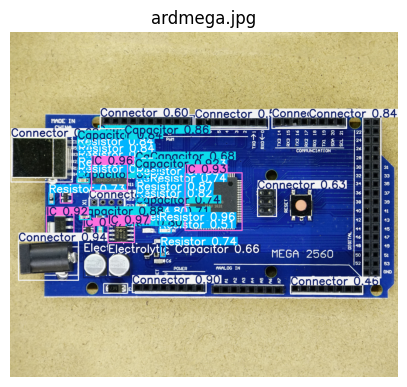

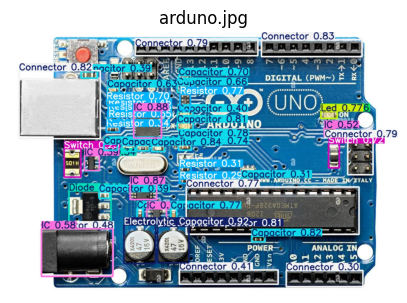

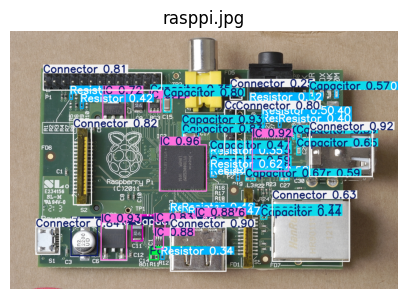

In [ ]:
import matplotlib.pyplot as plt
import cv2, os

eval_out_dir = os.path.join(base_dir, "runs", "pcb_eval")

for fname in sorted(os.listdir(eval_out_dir)):
    if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
        path = os.path.join(eval_out_dir, fname)
        img  = cv2.imread(path)
        img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.title(fname)
        plt.axis("off")
        plt.show()